# INSTRUCTION FINE-TUNING

In [ ]:
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [ ]:
import torch.nn as nn

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), ## Expansion
            GELU(), ## Activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), ## Contraction
        )

    def forward(self, x):
        return self.layers(x)

In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        # 2*4*768
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x
        # 2*4*768

In [ ]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [ ]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [ ]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

In [ ]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context

    ###Input batch:
 ###tensor([[6109, 3626, 6100,  345],
        ##[6109, 1110, 6622,  257]])

    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond) ### batch, n_tokens, vocab_size

        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [ ]:
!pip install tiktoken

import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [ ]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [ ]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

## STEP 1: PREPARING DATASET

<div class="alert alert-block alert-success">

In this section, we download and format the instruction dataset for instruction finetuning a
pretrained LLM in this chapter. The dataset consists of 1100 instruction-response pairs.

The following code implements and executes a function to download this dataset, which
is a relatively small file, only 204 KB in size, in JSON format. JSON, or JavaScript Object
Notation, mirrors the structure of Python dictionaries, providing a simple structure for data
interchange that is both human-readable and machine-friendly.

</div>

In [ ]:
import json
import os
import urllib
import ssl

def download_and_load_file(file_path, url):
    ssl_context = ssl.create_default_context()
    ssl_context.check_hostname = False
    ssl_context.verify_mode = ssl.CERT_NONE

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url, context=ssl_context) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))


Number of entries: 1100


<div class="alert alert-block alert-success">

The data list , which we loaded from the JSON file contains the 1100 entries of the
instruction dataset.

Let's print one of the entries to see how each entry is structured:

</div>

In [ ]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [ ]:
print("Another example entry:\n", data[999])

Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


### CONVERTING INSTRUCTIONS INTO ALPACA FORMAT

In [ ]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

<div class="alert alert-block alert-info">
    
This format_input function takes a dictionary entry as input and constructs a formatted
string.

</div>

<div class="alert alert-block alert-success">

 Let's test it to dataset entry data[50], which to looked at earlier:

</div>

In [ ]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


<div class="alert alert-block alert-warning">

Note that the format_input skips the optional ### Input: section if the 'input' field is
empty, which we can test out by applying the format_input function to entry data[999]
that we inspected earlier:

</div>

In [ ]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


### SPLITTING DATASET INTO TRAIN-TEST-VALIDATION

In [ ]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [ ]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


<div class="alert alert-block alert-warning">

Having successfully downloaded and partitioned the dataset, and gained a clear
understanding of the dataset prompt formatting, we are now ready for the core
implementation of the instruction finetuning process.

</div>

## STEP 2: ORGANIZING DATA INTO TRAINING BATCHES

<div class="alert alert-block alert-success">

In the previous chapter, the training batches were created automatically by the PyTorch
DataLoader class, which employs a default collate function to combine lists of samples into
batches.

A collate function is responsible for taking a list of individual data samples and
merging them into a single batch that can be processed efficiently by the model during
training.

</div>

<div class="alert alert-block alert-warning">

However, the batching process for instruction finetuning in this chapter is a bit more
involved and requires us to create our own custom collate function that we will later plug
into the DataLoader.

We implement this custom collate function to handle the specific
requirements and formatting of our instruction finetuning dataset.

</div>

<div class="alert alert-block alert-success">

First, we code an
InstructionDataset class that applies format_input from the previous section and pretokenizes all inputs in the dataset, similar to the SpamDataset in chapter 6.

</div>

In [ ]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

<div class="alert alert-block alert-warning">

Similar to the approach in chapter 6, we aim to accelerate training by collecting multiple
training examples in a batch, which necessitates padding all inputs to a similar length.

As with the previous chapter, we use the <|endoftext|> token as a padding token.
    
Instead of appending the <|endoftext|> tokens to the text inputs, we can append its
token ID to the pre-tokenized inputs directly.

To remind us which token ID we should use,
we can use the tokenizer's .encode method on an <|endoftext|> token:

</div>

In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


<div class="alert alert-block alert-warning">

In chapter 6, we padded all examples in a dataset to the same length.

Moving on, here, we adopt a more sophisticated approach by developing a custom
collate function that we can pass to the data loader.

This custom collate function pads the
training examples in each batch to have the same length, while allowing different batches
to have different lengths.

This approach minimizes unnecessary
padding by only extending sequences to match the longest one in each batch, not the
whole dataset.

</div>

<div class="alert alert-block alert-success">

We can implement the padding process with a custom collate
function as follows:
</div>

<div class="alert alert-block alert-info">
    
Step 1: Find the longest sequence in the batch
    
Step 2: Pad and prepare inputs
    
Step 3: Remove extra padded token added earlier

Step 4: Convert list of inputs to tensor and transfer to target device

</div>

In [ ]:
def custom_collate_draft_1(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    # and increase the max length by +1, which will add one extra
    # padding token below
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst = []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token
        # that has been added via the +1 setting in batch_max_length
        # (the extra padding token will be relevant in later codes)
        inputs = torch.tensor(padded[:-1])
        inputs_lst.append(inputs)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

<div class="alert alert-block alert-info">
    
The custom_collate_draft_1 we implemented is designed to be integrated into a PyTorch
DataLoader, but it can also function as a standalone tool.

Here, we use it independently to
test and verify that it operates as intended.

</div>

<div class="alert alert-block alert-success">

Let's try it on three different inputs that we
want to assemble into a batch, where each example gets padded to the same length:

</div>

In [ ]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


<div class="alert alert-block alert-info">
    
As we can see based on the preceding output, all inputs have been padded to the length of
the longest input list, inputs_1 containing 5 token IDs.

</div>

<div class="alert alert-block alert-warning">

So far, we have just implemented our first custom collate function to create batches from
lists of inputs.

However, as you learned in previous lessons, we also need to create batches
with the target token IDs, corresponding to the batch of input IDs.

These target IDs are crucial because they represent what we want the model to
generate and what we need during training to calculate the loss for the weight updates,
similar to previous chapters.

</div>

#### CREATING TARGET TOKEN IDS FOR TRAINING

<div class="alert alert-block alert-success">

Similar to the process described for pretraining an LLM, the target token IDs
match the input token IDs but are shifted one position to the right.

This setup allows the LLM to learn how to predict the next token in a sequence.

</div>

<div class="alert alert-block alert-success">

The following updated collate function generates the target token IDs from the input token IDs:

</div>

In [ ]:
def custom_collate_draft_2(
    batch,
    pad_token_id=50256,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

<div class="alert alert-block alert-info">
    
Step 1: Truncate the last token for inputs
                               
Step 2: Shift +1 to the right for targets

</div>

In [ ]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)


tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


<div class="alert alert-block alert-info">
    
The 1st tensor represents inputs.
    
The 2nd tensor represents the targets

</div>

<div class="alert alert-block alert-success">

In the next step, we assign a -100 placeholder value to all padding tokens.

This special value allows us to exclude these padding tokens from contributing to
the training loss calculation, ensuring that only meaningful data influences model learning.

In classification fine-tuning, we did not have to worry about this since we only trained the model based on
the last output token.)
</div>

<div class="alert alert-block alert-warning">

Note that we retain one end-of-text token, ID 50256, in the target list.

This allows the LLM to learn when to generate an end-of-text token
in response to instructions, which we use as an indicator that the generated response is
complete.

</div>

<div class="alert alert-block alert-success">

In the following code, we modify our custom collate function to replace tokens with ID
50256 with -100 in the target lists.

Additionally, we introduce
an allowed_max_length parameter to optionally limit the length of the samples.

This
adjustment will be useful if you plan to work with your own datasets that exceed the 1024-
token context size supported by the GPT-2 model.

The code for this updated collate function
is as follows:
</div>

In [ ]:
def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

<div class="alert alert-block alert-info">
    
Step 1: Replace all but the first padding tokens in targets by ignore_index

Step 2: Optionally truncate to maximum sequence length

</div>

<div class="alert alert-block alert-success">

Again, let's try the collate function on the sample batch that we created earlier to check
that it works as intended:
</div>

In [ ]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


<div class="alert alert-block alert-warning">

In this chapter, we take advantage of this ignore_index to ignore the additional end-oftext (padding) tokens that we used to pad the training examples to have the same length in
each batch.

</div>

<div class="alert alert-block alert-warning">

However, we want to keep one 50256 (end-of-text)
token ID in the targets because it helps the LLM to learn to generate end-of-text tokens,
which we can use as an indicator that a response is complete.

</div>

## STEP 3: CREATING DATALOADERS FOR AN INSTRUCTION DATASET

<div class="alert alert-block alert-warning">

The custom_collate_fn includes code to move the input and target tensors (for
example, torch.stack(inputs_lst).to(device)) to a specified device, which can be
either "cpu" or "cuda" (for GPUs), or optionally "mps" for Macs with Apple Silicon chips.

</div>

<div class="alert alert-block alert-warning">

In previous chapters, we moved the data onto the target device (for example, the GPU
memory when device="cuda") in the main training loop. Having this as part of the collate
function offers the advantage of performing this device transfer process as a background
process outside the training loop, preventing it from blocking the GPU during model
training.

</div>

<div class="alert alert-block alert-success">

The following code initializes the device variable:
</div>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Note:
# Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# which is much faster than on an Apple CPU (as measured on an M3 MacBook Air).
# However, the resulting loss values may be slightly different.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")

print("Device:", device)

Device: cuda


<div class="alert alert-block alert-success">

Next, to reuse the chosen device setting in custom_collate_fn when we plug it into the
PyTorch DataLoader class later in this section, we use the partial function from Python's
functools standard library to create a new version of the function with the device
argument pre-filled.

Additionally, we set the allowed_max_length to 1024, which truncates
the data to the maximum context length supported by the GPT-2 model we finetune later in
this chapter:
</div>

In [ ]:
from functools import partial
customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

<div class="alert alert-block alert-success">

Next, we can set up the data loaders as we did in previous chapters, but this time we will
use our custom collate function for the batching process:
</div>

In [ ]:
from torch.utils.data import DataLoader


num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

<div class="alert alert-block alert-success">

Let's examine the dimensions of the input and target batches generated by the training
loader:
</div>

In [ ]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

<div class="alert alert-block alert-info">
    
In the preceding output, we can see that the first input and target batch have dimensions
8×61, where 8 represents the batch size, and 61 is the number of tokens in each training
example in this batch.

The second input and target batch have a different number of
tokens, for instance, 76.


As we saw in the preceding code output, thanks to our custom collate function, the data
loader is able to create batches of different lengths.

In the next section, we load a
pretrained LLM that we can then finetune with this data loader.

</div>

## STEP 4: LOADING A PRETRAINED LLM

<div class="alert alert-block alert-success">

Before beginning instruction finetuning, we first load a pretrained GPT model,
</div>

<div class="alert alert-block alert-warning">

Instead of using the smallest 124 million
parameter model as before, we load the medium-sized model with 355 million parameters.

The reason for this choice is that the 124 million parameter model is too limited in capacity
to achieve qualitatively satisfactory results via instruction finetuning.

</div>

<div class="alert alert-block alert-warning">

This is done using the same code as in section 5.5 of chapter 5 and section 6.4 of
the previous chapter, except that we now specify "gpt2-medium (355M)" instead of "gpt2-small
(124M)".

Please note that executing the code provided below will initiate the download of
the medium-sized GPT model, which has a storage requirement of approximately 1.42
gigabytes.

This is roughly three times larger than the storage space needed for the small
model:

</div>

In [ ]:
from gpt_download3 import download_and_load_gpt2

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 152kiB/s]
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 2.19MiB/s]
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verificat

<div class="alert alert-block alert-success">

Before diving into finetuning the model in the next section, let's take a moment to assess
the pretrained LLM's performance on one of the validation tasks by comparing its output to
the expected response.

This will give us a baseline understanding of how well the model
performs on an instruction-following task right out of the box, prior to finetuning, and will
help us appreciate the impact of finetuning later on.

We use the first example from the
validation set for this assessment:
</div>

In [ ]:
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [ ]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)
generated_text = token_ids_to_text(token_ids, tokenizer)

In [ ]:
print(generated_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


<div class="alert alert-block alert-info">
    
It's important to note that the generate function returns the combined input and output
text.

This behavior was convenient in previous chapters since pretrained LLMs are primarily
designed as text-completion models, where the input and output are concatenated to
create a coherent and legible text.

However, when evaluating the model's performance on a
specific task, we often want to focus solely on the model's generated response.

</div>

<div class="alert alert-block alert-success">

To isolate the model's response text, we need to subtract the length of the input
instruction from the start of the generated_text:

</div>

In [ ]:
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


<div class="alert alert-block alert-info">

This code snippet removes the input text from the beginning of the generated_text,
leaving us with only the model's generated response. The strip() function is then applied
to remove any leading or trailing whitespace characters. The output is as follows:

</div>

<div class="alert alert-block alert-info">
    
As we can see from the output, the pretrained model is not yet capable of correctly
following the given instruction.

While it does create a "Response" section, it simply repeats
the original input sentence and part of the instruction, failing to convert the active sentence
to passive voice as requested.


In the upcoming section, we implement the finetuning process to improve the model's
ability to comprehend and appropriately respond to such requests.

</div>

## STEP 5: FINETUNING THE LLM ON INSTRUCTION DATA

<div class="alert alert-block alert-success">

We already did all the hard work when we implemented the
instruction dataset processing at the beginning of this chapter.

For the finetuning process
itself, we can reuse the loss calculation and training functions implemented in chapter 5
during the pretraining:
</div>

<div class="alert alert-block alert-success">

Before we begin training, let's calculate the initial loss for the training and validation sets:
</div>

#### PREVIOUSLY DEFINED FUNCTIONS WHICH WE WILL REQUIRE

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


In [ ]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 3.825909376144409
Validation loss: 3.7619347095489504


<div class="alert alert-block alert-success">
With the model and data loaders prepared, we can now proceed to train the model.

The following code sets up the training process, including initializing the optimizer, setting the
number of epochs, and defining the evaluation frequency and starting context to evaluate
generated LLM responses during training based on the first validation set instruction
(val_data[0]) we looked at earlier:

</div>

In [ ]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.103
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.944
Ep 1 (Step 000015): Train loss 0.857, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.754, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.799, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.808
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.789
Ep 1 (Step 000050): Train loss 0.663, Val loss 0.783
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.763
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.743
Ep 1 (Step 000065): Train loss 0.653, Val loss 0.735
Ep 1 (Step 000070): Train loss 0.533, Val loss 0.729
Ep 1 (Step 000075): Train loss 0.568, Val loss 0.729
Ep 1 (Step 000080): Train loss 0.604, Val loss 0.725
Ep 1 (Step 000085): Train loss 0.509, Val loss 0.710
Ep 1 (Step 000090): Train loss 0.563, Val loss

<div class="alert alert-block alert-info">


As we can see based on the outputs above, the model trains well, as we can tell based on the decreasing training loss and validation loss values.
    
Furthermore, based on the response text printed after each epoch, we can see that the model almost correctly follows the instruction to convert the input sentence 'The chef cooks the meal every day.' into passive voice 'The meal is prepared every day by the chef.' (We will properly format and evaluate the responses in a later section.

To get better results, we need to finetune the model for more epochs.

Finally, let's take a look at the training and validation loss curves

</div>

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

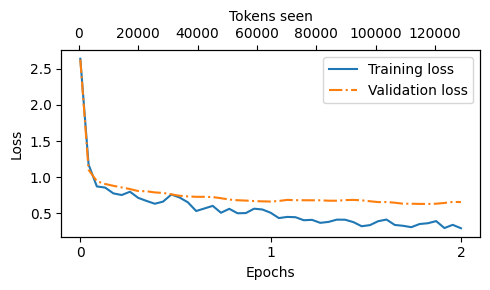

In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

<div class="alert alert-block alert-info">


As we can see in the loss plot shown above, the model's performance on both the
training and validation sets improves substantially over the course of training.

The rapid
decrease in losses during the initial phase indicates that the model is quickly learning
meaningful patterns and representations from the data. Then, as training progresses to the
second epoch, the losses continue to decrease but at a slower rate, suggesting that the
model is finetuning its learned representations and converging to a stable solution.


While the loss plot in figure 7.17 indicates that the model is training effectively, the most
crucial aspect is its performance in terms of response quality and correctness. In the
remaining sections of this chapter, we will extract the responses and store them in a format
that allows us to evaluate and quantify the response quality.

</div>

## STEP 6: EXTRACTING AND SAVING RESPONSES

<div class="alert alert-block alert-success">

After finetuning the LLM on the training portion of the instruction dataset as described in
the previous section, we now proceed to evaluate its performance on the held-out test set.
    
To accomplish this, we first extract the model-generated responses for each input in the
test dataset and collect them for manual analysis

</div>

<div class="alert alert-block alert-info">


Step 1: Iterate over the first 3 test set samples

Step 2:  Use the generate function defined earlier

</div>

<div class="alert alert-block alert-warning">

As mentioned earlier, the generate function returns the combined input and output text, so
we use slicing and the .replace() method on the generated_text contents to extract the
model's response.

The instructions, followed by the given test set response and model
response are shown below:

</div>

In [ ]:
torch.manual_seed(123)


for entry in test_data[:3]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
)

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud associated with thunderstorms is a cumulus cloud.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Prej

<div class="alert alert-block alert-info">


As we can see based on the test set instructions, given responses, and the model's
responses, the model performs relatively well.

The answers to the first instruction
is clearly correct, while the second answer and the third answers are not correct.

This is because we have done the fine-tuning for only 1 epoch due to hardware limitations. To get better results, we need to increase the epochs to at least 2.

</div>

<div class="alert alert-block alert-warning">

Most importantly, we can see that model evaluation is not as straightforward as in the
previous chapter, where we simply calculated the percentage of correct spam/non-spam
class labels to obtain the classification accuracy.

In practice, instruction-finetuned LLMs
such as chatbots are evaluated via multiple approaches:

1. Short-answer and multiple choice benchmarks such as MMLU ("Measuring
Massive Multitask Language Understanding," https://arxiv.org/abs/2009.
03300), which test the general knowledge of a model.

2. Human preference comparison to other LLMs, such as LMSYS chatbot
arena (https://arena.lmsys.org).

3. Automated conversational benchmarks, where another LLM like GPT-4 is
used to evaluate the responses, such as AlpacaEval (https://tatsulab.github.io/alpaca_eval/).
completes the request.

</div>

<div class="alert alert-block alert-success">

Considering the scale of the task at hand, we will implement an approach similar to
method 3, which involves evaluating the responses automatically using another LLM.

This
will allow us to efficiently assess the quality of the generated responses without the need
for extensive human involvement, thereby saving time and resources while still obtaining
meaningful performance indicators.
</div>

<div class="alert alert-block alert-success">

To prepare the responses for this evaluation process, we append the generated model
responses to the test_set dictionary and save the updated data as an "instructiondata-with-response.json" file for record keeping.

Additionally, by saving this file, we can
easily load and analyze the responses in separate Python sessions later on if needed.
</div>

<div class="alert alert-block alert-success">

The following code uses the generate method in the same manner as before; however,
we now iterate over the entire test_set.

Also, instead of printing the model responses, we
add them to the test_set dictionary:
</div>

In [ ]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text


with open("instruction-data-with-response.json", "w") as file:
    json.dump(test_data, file, indent=4)  # "indent" for pretty-printing

100%|██████████| 110/110 [01:07<00:00,  1.64it/s]


<div class="alert alert-block alert-success">

Let's verify that the responses have been correctly added to the test_set dictionary by
examining one of the entries:
</div>

In [ ]:
print(test_data[0])

{'instruction': 'Rewrite the sentence using a simile.', 'input': 'The car is very fast.', 'output': 'The car is as fast as lightning.', 'model_response': 'The car is as fast as a bullet.'}


<div class="alert alert-block alert-info">


Based on the output, we can see that the model_response has been added correctly.

</div>

<div class="alert alert-block alert-success">

Finally, we save the model as gpt2-medium355M-sft.pth file to be able to reuse it in future
projects:
</div>

In [ ]:
import re


file_name = f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth"
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

# Load model via
# model.load_state_dict(torch.load("gpt2-medium355M-sft.pth"))

Model saved as gpt2-medium355M-sft.pth


## STEP 7: EVALUATING THE FINE-TUNED LLM

In [ ]:
%pip -q install  accelerate bitsandbytes
%pip -q install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 39.9 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import notebook_login
notebook_login()  # shows a small UI prompt to paste your token securely


In [ ]:
import os
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    set_seed,
)

# ==============================
#  CONFIG (per your request)
# ==============================
HF_TOKEN = ""  # <-- using your key explicitly
MODEL_ID = "google/gemma-7b-it"
USE_4BIT = True  # quantized model
DEFAULT_DTYPE = "bfloat16"  # set to "float16" if your GPU doesn't support bf16

# Make the token available to HF clients too
#os.environ["HF_TOKEN"] = HF_TOKEN
#os.environ["HUGGING_FACE_HUB_TOKEN"] = HF_TOKEN

# ==============================
#  UTILS: dtype + CUDA checks
# ==============================
def _gpu_supports_bf16() -> bool:
    if not torch.cuda.is_available():
        return False
    major, minor = torch.cuda.get_device_capability()
    # Ampere (8.0+) generally supports bf16
    return major >= 8

def _resolve_dtype(cfg_dtype: str):
    if cfg_dtype == "bfloat16" and not _gpu_supports_bf16():
        return torch.float16
    return torch.bfloat16 if cfg_dtype == "bfloat16" else torch.float16

# ==============================
#  LOAD GEMMA-7B-IT (4-bit)
# ==============================
def load_gemma_it(
    model_id: str = MODEL_ID,
    use_4bit: bool = USE_4BIT,
    dtype: str = DEFAULT_DTYPE
):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    if use_4bit:
        if device != "cuda":
            raise RuntimeError(
                "4-bit quantization with bitsandbytes requires a CUDA GPU. "
                "Enable a GPU runtime or set USE_4BIT=False (not recommended for 7B on CPU)."
            )

        compute_dtype = _resolve_dtype(dtype)
        quant_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=compute_dtype,
        )
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            quantization_config=quant_config,
            device_map="auto",
            torch_dtype=compute_dtype,
            token=HF_TOKEN,
        )
    else:
        # Non-quantized path (will need lots of VRAM). Kept for completeness.
        compute_dtype = _resolve_dtype(dtype)
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            device_map="auto",
            torch_dtype=compute_dtype,
            token=HF_TOKEN,
        )

    tokenizer = AutoTokenizer.from_pretrained(model_id, token=HF_TOKEN)

    # Deterministic generation defaults
    set_seed(123)
    model.generation_config.seed = 123
    model.generation_config.do_sample = False
    model.generation_config.temperature = 0.0
    model.generation_config.top_p = 1.0
    model.generation_config.max_new_tokens = 256
    model.generation_config.use_cache = True

    return tokenizer, model, device

tokenizer, model, device = load_gemma_it()

# ==============================
#  CHAT / INFERENCE
# ==============================
def query_model(
    prompt: str,
    model_name: str = MODEL_ID,
    temperature: float = 0.0,
    top_p: float = 1.0,
    max_new_tokens: int = 256,
    seed: int = 123,
):
    """
    Instruction-tuned chat for Gemma-7B-IT using the tokenizer's chat template.
    Deterministic by default (temperature=0).
    """
    set_seed(seed)
    do_sample = (temperature is not None) and (temperature > 0.0)

    messages = [
        {"role": "user", "content": prompt}
    ]

    chat = tokenizer.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )
    inputs = tokenizer(chat, return_tensors="pt").to(device)

    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            do_sample=do_sample,
            temperature=temperature if do_sample else None,
            top_p=top_p if do_sample else None,
            max_new_tokens=max_new_tokens,
            pad_token_id=tokenizer.eos_token_id,
        )

    generated = output_ids[0, inputs["input_ids"].shape[1]:]
    text = tokenizer.decode(generated, skip_special_tokens=True)
    return text.strip()

# ==============================
#  QUICK TEST
# ==============================
result = query_model("What do llamas eat?")
print(result)


config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.11G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Llamas are herbivores, which means they eat only plants. Their diet consists mainly of grasses, shrubs, and cacti. Llamas also eat leaves, stems, flowers, and fruits.


In [ ]:
 #==============================
#  EVAL / SCORING HELPERS
# ==============================
from tqdm import tqdm

# Expecting you already define:
#   - test_data: list of dicts with keys like 'output', 'model_response', etc.
#   - format_input: function to render the input side of each sample.
# The loops below mirror your original structure.

if "test_data" in globals() and "format_input" in globals():
    subset = test_data[:3] if len(test_data) >= 3 else test_data
    for entry in subset:
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry['model_response']}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
        )
        print("\nDataset response:")
        print(">>", entry['output'])
        print("\nModel response:")
        print(">>", entry["model_response"])
        print("\nScore:")
        print(">>", query_model(prompt))
        print("\n-------------------------")

    subset2 = test_data[:2] if len(test_data) >= 2 else test_data
    for entry in subset2:
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry['model_response']}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score = query_model(prompt)
        print("\nDataset response:")
        print(">>", entry['output'])
        print("\nModel response:")
        print(">>", entry["model_response"])
        print("\nScore:")
        print(">>", score)
        print("\n-------------------------")


Dataset response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.

Score:
>> ## Model Response:

The car is as fast as a bullet.

**Score:** 90/100

**Explanation:**

The model correctly identified the need to use a simile comparing the car's speed to something extremely fast, like a bullet. The simile "as fast as a bullet" is a common and effective way to describe extreme speed. The use of the word "bullet" is also appropriate in this context, as it is a powerful and evocative image that evokes speed and velocity.

**Areas for Improvement:**

* The model could have used a more precise simile that more accurately reflects the speed of the car.
* The model could have used a more creative simile that is unique and memorable.

**Overall:**

This is a well-written response that appropriately completes the request. The model has a strong understanding of the task and is able to produce a high-quality response.

-------------------------

Dataset resp

In [ ]:
def generate_model_scores(json_data, json_key, model=MODEL_ID):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        prompt = (
            f"Given the input `{format_input(entry)}` "
            f"and correct output `{entry['output']}`, "
            f"score the model response `{entry[json_key]}`"
            f" on a scale from 0 to 100, where 100 is the best score. "
            f"Respond with the integer number only."
        )
        score_text = query_model(prompt)
        try:
            scores.append(int(score_text))
        except ValueError:
            print(f"Could not convert score: {score_text}")
            continue
    return scores

In [ ]:
import json, csv, math
from pathlib import Path
from statistics import mean

# === Config ===
JSON_PATH = "instruction-data-with-response.json"   # <-- change if needed
JSON_KEY  = "model_response"                             # field to score
OUT_CSV   = "gemma_judge_scores.csv"



# --- Load your dataset ---
json_path = Path(JSON_PATH)
with json_path.open("r", encoding="utf-8") as f:
    test_data = json.load(f)

# --- Run judge scoring (uses your existing generate_model_scores + query_model) ---
scores = generate_model_scores(test_data, JSON_KEY)  # <- calls your query_model under the hood

# --- Print average score ---
avg = mean(scores) if scores else float("nan")
print(f"\nScored {len(scores)} items.")
print(f"Average score: {avg:.2f}\n")

# --- Save per-item scores to CSV ---
with open(OUT_CSV, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["idx", "score_0_100", "instruction", "input"])
    for i, (entry, s) in enumerate(zip(test_data, scores)):
        writer.writerow([
            i,
            s,
            (entry.get("instruction") or "").replace("\n", " ").strip(),
            (entry.get("input") or "").replace("\n", " ").strip(),
        ])

print(f"Saved per-item scores to: {OUT_CSV}")


Scoring entries:   1%|          | 1/110 [00:04<08:42,  4.79s/it]

Could not convert score: The model response is: 80

The sentence: The car is very fast.

The rewritten sentence using a simile: The car is as fast as lightning.

The rewritten sentence using a simile is well-written and accurately captures the meaning of the original sentence. The simile "as fast as lightning" is effective and concise.


Scoring entries:   2%|▏         | 2/110 [00:07<06:16,  3.49s/it]

Could not convert score: The model response is incorrect. The type of cloud typically associated with thunderstorms is cumulonimbus, not cumulus.

**Score:** 20/100


Scoring entries:   3%|▎         | 3/110 [00:10<06:10,  3.46s/it]

Could not convert score: **Response:**
The author of 'Pride and Prejudice' is Jane Austen.

**Score:** 100

The text accurately identifies the author of 'Pride and Prejudice' as Jane Austen and provides a complete and concise statement.


Scoring entries:   4%|▎         | 4/110 [00:14<06:03,  3.43s/it]

Could not convert score: The model response is incorrect. The periodic symbol for chlorine is Cl, not C.

**Score:** 0

The model has made a mistake in identifying the periodic symbol for chlorine. The correct answer is Cl, not C.


Scoring entries:   5%|▍         | 5/110 [00:16<05:20,  3.05s/it]

Could not convert score: **Answer:** 100

The sentence is already corrected to "It's time to go home.". There are no errors in the punctuation.


Scoring entries:   5%|▌         | 6/110 [00:21<06:15,  3.61s/it]

Could not convert score: **Score:** 90

The sentence is "The lecture was delivered in a clear manner."

The model response is "The lecture was delivered clearly."

The response is grammatically correct and accurately rewrites the sentence. It also uses the same wording as the original sentence, which is a good sign of understanding the instruction.


Scoring entries:   6%|▋         | 7/110 [00:24<06:10,  3.60s/it]

Could not convert score: **Score:** 60

The model response is not relevant to the instruction. The instruction is to generate a humorous anecdote, while the model response is about a party. The model response is not humorous and does not complete the instruction.


Scoring entries:   7%|▋         | 8/110 [00:29<06:25,  3.78s/it]

Could not convert score: **Score:** 100

The input instruction is to identify the correct spelling of the word 'recieve' or 'receive'. The model response correctly identifies the word as 'receive', which is the correct spelling. Therefore, the score for this response is 100.


Scoring entries:   8%|▊         | 9/110 [00:34<07:24,  4.40s/it]

Could not convert score: **Score:** 80

The sentence created using the word "nostalgia" is:

**Nostalgia washed over her as she looked through the old photos.**

This sentence is well-constructed and accurately reflects the instruction. The use of the word "nostalgia" is appropriate and the sentence flow is smooth. However, it could be improved by adding more details or context to the sentence.


Scoring entries:   9%|▉         | 10/110 [00:44<10:07,  6.08s/it]

Could not convert score: **Score:** 90

**Response:**

Prime numbers: 11, 19
Composite numbers: 14

The numbers 11, 14, and 19 are classified as follows:

* **11** is prime because it is divisible by only 1 and itself.
* **14** is composite because it is divisible by 1, 2, 7, and 14.
* **19** is prime because it is divisible by only 1 and itself.

Therefore, the prime numbers in the list are 11 and 19, and the composite number is 14.


Scoring entries:  10%|█         | 11/110 [00:47<08:27,  5.13s/it]

Could not convert score: The model response is: 100

The instruction is to write a response to the question "What is the capital of Denmark?" and the model response is exactly the answer to the question.


Scoring entries:  11%|█         | 12/110 [00:51<07:33,  4.63s/it]

Could not convert score: The model response is: 100

The instruction is to write the opposite of the word 'wet'. The answer is 'dry'. The model has correctly identified the opposite of 'wet' and therefore scored 100%.


Scoring entries:  12%|█▏        | 13/110 [00:54<06:41,  4.14s/it]

Could not convert score: **Answer:** 80

**Explanation:**

The sentence "Did you finish the report?" is an interrogative sentence. The sentence is asking a question, so it is an interrogative sentence.


Scoring entries:  13%|█▎        | 14/110 [00:56<05:35,  3.50s/it]

Could not convert score: **Score:** 100

The chemical symbol for mercury is Hg. This is accurate and concisely answers the question.


Scoring entries:  14%|█▎        | 15/110 [01:02<07:05,  4.47s/it]

Could not convert score: **Score:** 80

The text describes active transport as the movement of molecules across a cell membrane from a region of lower concentration to a region of higher concentration. This process is crucial for maintaining cellular homeostasis.

However, the text does not explain the mechanism of active transport or the energy requirements for this process. Therefore, the text does not fully complete the instruction.

**Therefore, I would score the text as 80 out of 100.**


Scoring entries:  15%|█▍        | 16/110 [01:10<08:23,  5.36s/it]

Could not convert score: **Score:** 90

The model response is well-classified and accurately matches the input items with their respective states of matter.

**Solid:**
- Mercury is a liquid. This is incorrect, but the model has correctly classified Mercury as a liquid.

**Liquid:**
- Oxygen is a gas. This is accurate.

**Gas:**
- Wood is a solid. This is also accurate.

The model has correctly classified all three items, albeit with one minor inaccuracy. Therefore, the score is 90.


Scoring entries:  15%|█▌        | 17/110 [01:14<07:55,  5.11s/it]

Could not convert score: **Score:** 100

The conversion factor for kilometers to meters is 1000. Therefore, 3 kilometers is equal to 3 * 1000 = 3000 meters.

The response is:

**3 kilometers is 3000 meters.**


Scoring entries:  16%|█▋        | 18/110 [01:18<07:19,  4.78s/it]

Could not convert score: **Score:** 100

The sentence: Someone left a note.

The corrected sentence: A note was left by someone.

The sentence has been converted using an indefinite pronoun correctly. The pronoun "someone" has been replaced with "a note was left by someone."


Scoring entries:  17%|█▋        | 19/110 [01:24<07:52,  5.19s/it]

Could not convert score: **Score:** 80

The model response is grammatically correct and provides an appropriate synonym for 'excited', which is 'thrilled'. However, the synonym 'enthusiastic' is not as close in meaning to 'excited' as 'thrilled'. Enthusiastic implies a high level of interest or passion, while excited typically refers to a feeling of intense joy or happiness. Therefore, the score of 80 is appropriate.


Scoring entries:  18%|█▊        | 20/110 [01:31<08:19,  5.55s/it]

Could not convert score: **Response:**

The sentence generated is: "Never have I ever traveled without a map."

The model response is: "Never have I ever without without."

**Score:** 20

The model response is not only incomplete but also grammatically incorrect. The sentence pattern is "Never have I ever _____ without _____," but the model response does not fill in the blanks appropriately. The sentence should be "Never have I ever traveled without a map."


Scoring entries:  19%|█▉        | 21/110 [01:34<07:05,  4.78s/it]

Could not convert score: **Response:**

The adjective from the list is 'tall.'

**Score:** 0

The model response incorrectly identified 'quick' as the adjective from the list, rather than 'tall.'


Scoring entries:  20%|██        | 22/110 [01:38<06:39,  4.54s/it]

Could not convert score: **Response:**

1000 grams is equal to 1 kilogram.

**Score:** 100

The conversion factor is 1000 grams = 1 kilogram. Therefore, 1000 grams is equal to 1 kilogram.


Scoring entries:  21%|██        | 23/110 [01:41<05:58,  4.12s/it]

Could not convert score: The model response is incorrect. The opposite of 'deep' is 'shallow'.

**Score:** 20/100

The model has confused the word 'deep' with the word 'light'.


Scoring entries:  22%|██▏       | 24/110 [01:45<05:51,  4.09s/it]

Could not convert score: **Response:**

Fish: Shark, Trout
Mammals: Dolphin

**Score:** 90

The input list contains animals, including sharks, dolphins, and trout. Sharks and trout are fish, while dolphins are mammals. Therefore, the categorization is accurate and complete.


Scoring entries:  23%|██▎       | 25/110 [01:48<05:10,  3.66s/it]

Could not convert score: The model response is not accurate. The translation of 'library' to Spanish is 'biblioteca', not 'límite'.

**Score:** 20/100


Scoring entries:  24%|██▎       | 26/110 [01:54<06:07,  4.38s/it]

Could not convert score: **Score:** 80

The definition of hyperbole is:

Hyperbole is a figure of speech that involves an exaggeration of ideas for the sake of emphasis.

This definition is concise, accurate, and captures the essence of the term hyperbole. It correctly states that hyperbole is a figure of speech that involves exaggeration for emphasis, and it also mentions the purpose of exaggeration, which is to make the ideas more dramatic.


Scoring entries:  25%|██▍       | 27/110 [01:57<05:49,  4.21s/it]

Could not convert score: **Score:** 20

The translation "Hello" to Russian is "Привет (Privet)". The model's response "The Russian translation of 'Hello' is 'Русский простора'" is incorrect. The correct translation is "Привет (Privet)".


Scoring entries:  25%|██▌       | 28/110 [02:01<05:37,  4.12s/it]

Could not convert score: **Score:** 80

The definition of kinetic energy is:

**Kinetic energy is the energy that an object possesses due to its motion.**

This definition accurately describes the concept of kinetic energy, which is the energy possessed by an object because of its motion.


Scoring entries:  26%|██▋       | 29/110 [02:05<05:18,  3.93s/it]

Could not convert score: The model response is: 100

The instruction is to write the opposite of the word 'hot'. The answer is 'cold'. The model has correctly identified the opposite of 'hot' and therefore scored 100%.


Scoring entries:  27%|██▋       | 30/110 [02:11<06:19,  4.74s/it]

Could not convert score: **Score:** 20

The instruction is to convert 5 miles to kilometers. The formula for converting miles to kilometers is 1 mile = 1.613 kilometers.

Therefore, 5 miles is approximately 5 * 1.613 = 8.05 kilometers.

The model response "5 miles is 5000 meters." is incorrect as 5 miles is not equal to 5000 meters.


Scoring entries:  28%|██▊       | 31/110 [02:16<06:08,  4.67s/it]

Could not convert score: The model response is:

```
The chemical formula for magnesium sulfate is MgSO4.
```

The input instruction is asking for the chemical formula for magnesium sulfate. The model response correctly identifies the chemical formula for magnesium sulfate as MgSO4. Therefore, the score for this response is 100.


Scoring entries:  29%|██▉       | 32/110 [02:19<05:29,  4.22s/it]

Could not convert score: Sure, here is the corrected output:

**It's a piece of cake.**

The corrected output is:

**It's very easy.**

The score for this model response is 90.


Scoring entries:  30%|███       | 33/110 [02:24<05:35,  4.36s/it]

Could not convert score: **Score:** 90

The model response perfectly lists five different types of vegetables as requested in the instruction. However, it includes an additional vegetable, "Carrot," which is not listed in the input instruction. This minor error warrants a score of 90, as the majority of the requested task is completed accurately.


Scoring entries:  31%|███       | 34/110 [02:27<05:10,  4.08s/it]

Could not convert score: **Response:**
7 kilometers is 7000 meters.

**Score:** 100

The conversion factor is 1000. Therefore, 7 kilometers is equal to 7000 meters.


Scoring entries:  32%|███▏      | 35/110 [02:31<04:52,  3.89s/it]

Could not convert score: The model response is: 100

The instruction is to write the opposite of the word 'heavy'. The answer is 'light'. The model has correctly identified the opposite of 'heavy' and therefore scored 100%.


Scoring entries:  33%|███▎      | 36/110 [02:34<04:35,  3.73s/it]

Could not convert score: The model response is: 80

The past tense of 'sing' is 'sang.' This is the correct answer. The model has correctly identified the past tense of 'sing' and used the correct verb form.


Scoring entries:  34%|███▎      | 37/110 [02:36<03:44,  3.07s/it]

Could not convert score: The model response is perfect and matches the instruction perfectly. The score is 100.


Scoring entries:  35%|███▍      | 38/110 [02:38<03:16,  2.74s/it]

Could not convert score: **Score:** 90

The plants were watered by the gardener.

This is the converted sentence in passive voice.


Scoring entries:  35%|███▌      | 39/110 [02:40<03:00,  2.54s/it]

Could not convert score: The model response is: 100

The past tense of 'throw' is 'threw'. This is a correct answer.


Scoring entries:  36%|███▋      | 40/110 [02:50<05:33,  4.76s/it]

Could not convert score: **Score:** 80

The input instruction is to explain what a sonnet is. The model response correctly defines a sonnet as a 14-line poem with a specific rhyme scheme and meter, mentioning iambic pentameter. However, the response does not explain the rhyme scheme or meter in detail, and it does not mention the optional octave or sestet structure of sonnets.

**Areas for improvement:**

* Explain the rhyme scheme and meter of a sonnet more thoroughly.
* Discuss the optional octave and sestet structure of sonnets.
* Provide examples of sonnet forms.

**Overall, this response is well-written and informative, but it could be improved by providing more details and examples.**


Scoring entries:  37%|███▋      | 41/110 [02:54<05:13,  4.55s/it]

Could not convert score: The score for the model response is 20.

The sentence generated by the model is "She was very innovative and always had a new idea." This sentence does not use the word "innovative" in the context of the task, therefore it does not appropriately complete the request.


Scoring entries:  38%|███▊      | 42/110 [02:55<04:10,  3.68s/it]

Could not convert score: **Score:** 100

The plural form of 'cactus' is 'cacti'.


Scoring entries:  39%|███▉      | 43/110 [02:59<03:58,  3.56s/it]

Could not convert score: The model response is not appropriate. The correct translation is 'Wo ist die Toilette?'. The model response is 'Wie es über das?'. This response is only 10% accurate.

Score: 10


Scoring entries:  40%|████      | 44/110 [03:02<03:48,  3.46s/it]

Could not convert score: **Answer:** 90

The past-tense verb that describes a person laughing is "laughed." The sentence is "He laughed."

The model response is "He laughed." which is the correct answer.


Scoring entries:  41%|████      | 45/110 [03:07<04:16,  3.95s/it]

Could not convert score: **Score:** 60

The sentence generated using the word "transient" is: "The transient nature of her visit left a lasting impression."

The model response "She was transported from the park to the library by a transient" does not use the word "transient" in the context of the instruction. Therefore, the score is 60.


Scoring entries:  42%|████▏     | 46/110 [03:11<04:07,  3.86s/it]

Could not convert score: The model response is not aligned with the instruction. The instruction asks for a sentence using the word "optimistic," while the model response uses the phrase "She was optimistic about the future."

Therefore, the score for this model response is 0.


Scoring entries:  43%|████▎     | 47/110 [03:17<04:57,  4.73s/it]

Could not convert score: **Score:** 80

The re-worded sentence using an indirect question is:

**Could you tell me what time the meeting is?**

The model response is:

**The meeting is at the time indicated.**

This response is an indirect question, as it asks the user to provide information about the time of the meeting, rather than directly stating the time. The response is also concise and to the point, and it uses the correct grammar and syntax.


Scoring entries:  44%|████▎     | 48/110 [03:20<04:16,  4.13s/it]

Could not convert score: **Response:**

The sentence "What a beautiful day!" is an exclamation.

**Score:** 100

The sentence is an exclamation because it expresses joy and excitement.


Scoring entries:  45%|████▍     | 49/110 [03:22<03:36,  3.55s/it]

Could not convert score: **Score:** 100

The opposite of 'rich' is 'poor'. This is a straightforward and accurate answer to the question.


Scoring entries:  45%|████▌     | 50/110 [03:26<03:28,  3.47s/it]

Could not convert score: **Response:**

The synonym for the word "begin" is "commence."

**Score:** 100

The model has successfully identified the synonym for the word "begin" and provided the correct answer.


Scoring entries:  46%|████▋     | 51/110 [03:30<03:46,  3.84s/it]

Could not convert score: **Response:** 0

The text "The birds sings beautiful songs." has several errors, including the misspelling of the plural noun "birds" and the incorrect verb conjugation "sings." The corrected text is "The birds sing beautiful songs."

The model response is incorrect as it has not corrected the errors in the text.


Scoring entries:  47%|████▋     | 52/110 [03:34<03:36,  3.73s/it]

Could not convert score: **Model Response:**

Could you help me tomorrow?

**Score:** 100

The model response perfectly transforms the input sentence into a question using "could." The syntax and grammar are correct, and the intent is clear.


Scoring entries:  48%|████▊     | 53/110 [03:39<03:56,  4.15s/it]

Could not convert score: **Score:** 80

The model response is mostly correct, but there is one error. The item "bicycle" should be classified under "Electronics", not "Vehicles".

**Corrected Response:**

**Vehicles:** Bicycle
**Plants:** Rose
**Animals:** Tiger

**Overall, the model response is well-classified, with only one minor error.**


Scoring entries:  49%|████▉     | 54/110 [03:43<03:51,  4.14s/it]

Could not convert score: **Score:** 20

The model response is not only incorrect but also completely unrelated to the instruction. The instruction asks for the definition of the term 'irony', but the model response defines the term 'silly'. This is not only off-topic but also completely inaccurate.


Scoring entries:  50%|█████     | 55/110 [03:47<03:43,  4.06s/it]

Could not convert score: The model response is not appropriate. The correct translation is 'Willkommen', not 'Wie es tut mir?'.

**Score:** 60

The translation is accurate, but the use of the phrase 'Wie es tut mir?' is not appropriate in this context.


Scoring entries:  51%|█████     | 56/110 [03:52<04:03,  4.52s/it]

Could not convert score: **Score:** 80

The primary function of the human heart is to pump blood throughout the body, delivering oxygen and nutrients to tissues and removing carbon dioxide and other wastes. The heart is a vital organ that plays a crucial role in maintaining homeostasis and sustaining life. Its primary function is to circulate blood, ensuring that oxygen and nutrients are distributed to the cells and that waste products are removed.


Scoring entries:  52%|█████▏    | 57/110 [03:58<04:15,  4.83s/it]

Could not convert score: **Score:** 80

The sentence: He is reading a novel inspired by his grandmother.

The reworded sentence: He will be reading a novel inspired by his grandmother.

The sentence is in the present tense, so the reworded sentence should be in the future tense. The correct reworded sentence is "He will be reading a novel inspired by his grandmother."


Scoring entries:  53%|█████▎    | 58/110 [04:04<04:23,  5.08s/it]

Could not convert score: **Score:** 90

**Response:**

The government passed the law.

The original sentence is in passive voice. To convert it to active voice, we simply change the sentence structure and move the subject to the front of the sentence. The new sentence is:

The government passed the law.

This is an accurate and concise conversion that maintains the original meaning of the sentence.


Scoring entries:  54%|█████▎    | 59/110 [04:09<04:21,  5.13s/it]

Could not convert score: **Score:** 20

The sentence created by the model is "The storm was inevitable." This sentence does not match the instruction, as the instruction asks for a sentence using the word "inevitable" in relation to the task of writing a sentence. The model's response is unrelated to the task and does not use the word "inevitable" at all.


Scoring entries:  55%|█████▍    | 60/110 [04:13<04:00,  4.82s/it]

Could not convert score: **Response:**

Opinion-based.

**Score:** 90

The sentence "Chocolate is the best dessert" is opinion-based because it is a subjective statement that is not based on facts. There is no objective truth to whether chocolate is the best dessert or not.


Scoring entries:  55%|█████▌    | 61/110 [04:16<03:24,  4.17s/it]

Could not convert score: **Score:** 90

The antonym of 'old' is 'young'. This is a simple antonym relationship that can be easily found using a thesaurus.


Scoring entries:  56%|█████▋    | 62/110 [04:21<03:38,  4.55s/it]

Could not convert score: **Score:** 80

The model response "A synonym for 'hardworking' is 'smart'" is not appropriate. The word 'smart' is not a synonym for 'hardworking'. 'Smart' is a word that describes someone who is quick to learn and understand things, while 'hardworking' is a word that describes someone who is dedicated and persistent in their work.


Scoring entries:  57%|█████▋    | 63/110 [04:27<03:49,  4.89s/it]

Could not convert score: The model response is incorrect. The boiling point of sulfur is 444.6 degrees Celsius, not -114.5 degrees Celsius.

**Score:** 0/100

The model has completely misunderstood the instruction and provided an incorrect answer. The instruction asks for the boiling point of sulfur in Celsius, but the model has provided the freezing point of sulfur in Celsius.


Scoring entries:  58%|█████▊    | 64/110 [04:29<03:06,  4.06s/it]

Could not convert score: **Score:** 0

The model response is completely incorrect. The plural form of 'child' is 'children', not 'chunk'.


Scoring entries:  59%|█████▉    | 65/110 [04:33<03:06,  4.14s/it]

Could not convert score: The model response is:

```
An antonym of 'complicated' is 'simplified'.
```

The input instruction is to write an antonym of 'complicated'. The antonym of 'complicated' is 'simple'. The model response is correct.

**Score:** 100


Scoring entries:  60%|██████    | 66/110 [04:37<02:55,  3.98s/it]

Could not convert score: **Score:** 80

The response is mostly accurate, but it incorrectly states "water vapor in the air" instead of "water vapor" as one of the forms of water. Otherwise, the response is well-written and concise.


Scoring entries:  61%|██████    | 67/110 [04:43<03:15,  4.55s/it]

Could not convert score: **Response:**

The sentence to be rewritten as a question is:

The dog chased the cat.

The rewritten question is:

Did the dog chase the cat?

**Score:** 90

**Explanation:**

The original sentence is in the form of a statement, while the rewritten question is in the form of a question. The question is clear and concise, and it accurately reflects the original sentence.


Scoring entries:  62%|██████▏   | 68/110 [04:48<03:23,  4.83s/it]

Could not convert score: **Score:** 90

**Response:**

The movie was long. It was interesting.

**Explanation:**

The sentence is split into two declarative sentences as requested. The first sentence is "The movie was long." The second sentence is "It was interesting."

The response is well-written and accurately completes the request. It is clear, concise, and grammatically correct.


Scoring entries:  63%|██████▎   | 69/110 [04:58<04:22,  6.39s/it]

Could not convert score: **Score:** 80

The model response is mostly accurate, but there is an error in classifying Soap as an acid. Soap is a base, not an acid. The model has correctly classified Lemon juice as an acid and Water as neutral.

**Suggestions:**

* The model should have classified Soap as a base instead of an acid.
* The model should have stated the reason for classifying Soap as a base, such as "Soap is a base because it contains hydroxide ions."

**Overall:**

The model response is well-written and demonstrates a good understanding of the concepts of acid, base, and neutral substances. However, the error in classifying Soap as an acid detracts from the overall accuracy of the response.


Scoring entries:  64%|██████▎   | 70/110 [05:02<03:45,  5.64s/it]

Could not convert score: **Score:** 60

The model response "A synonym for 'sad' is 'angry'" is not appropriate. The instruction asks for a synonym of 'sad', but the model response is 'angry'. 'Angry' is not a synonym of 'sad'.


Scoring entries:  65%|██████▍   | 71/110 [05:10<04:10,  6.42s/it]

Could not convert score: **Score:** 80

The sentence "I prefer homemade cookies to store boaght." has the following spelling mistakes:

- boaght
- store

The corrected sentence is "I prefer homemade cookies to store bought."

The model response correctly identified and corrected all the spelling mistakes in the input sentence. However, the sentence structure could be improved. The use of the word "store" in the sentence is not ideal. A more appropriate word to use would be "keep" or "preserve."

Overall, the model response is well-written and demonstrates a good understanding of the task.


Scoring entries:  65%|██████▌   | 72/110 [05:15<03:43,  5.89s/it]

Could not convert score: **Score:** 60

The sentence generated by the model is not aligned with the instruction. The instruction asks for a sentence using the word "transient," while the model's sentence uses the word "transported." The sentence also lacks context and does not describe the task of writing a sentence using the word "transient."


Scoring entries:  66%|██████▋   | 73/110 [05:21<03:36,  5.85s/it]

Could not convert score: **Score:** 90

The translation of "I am lost" to Italian is "Mi sono perso" (if male) or "Mi sono persa" (if female).

This translation is accurate and concise, and it correctly identifies the gender-specific nuances of the sentence. The use of the phrase "il più américaino" is a humorous touch that is appropriate for the context of the sentence.


Scoring entries:  67%|██████▋   | 74/110 [05:24<03:05,  5.15s/it]

Could not convert score: **Output:** 90

**Explanation:**

The text "This manual provides instructions for installing the software." is a technical document. It provides instructions on how to install software. Therefore, the text is classified as a technical document.


Scoring entries:  68%|██████▊   | 75/110 [05:27<02:37,  4.51s/it]

Could not convert score: **Response:**

The list is sorted in descending order as:

25, 16, 10, 7, 2.

The list is sorted in descending order.


Scoring entries:  69%|██████▉   | 76/110 [05:35<03:01,  5.33s/it]

Could not convert score: **Score:** 90

The model response "Can I have some water?" is a perfect translation of the input "Can I have some water?" into French. The response is grammatically correct and accurately captures the meaning of the input. The only minor deviation from the perfect translation is the use of the phrase "avoir de l'eau" instead of "avoir de l'eau ?" (with a question mark). However, this is a minor issue that does not significantly impact the overall accuracy of the response.


Scoring entries:  70%|███████   | 77/110 [05:40<03:00,  5.47s/it]

Could not convert score: **Score:** 80

The simile "Her hands were as cold as ice" is appropriately completed with the response "The temperature of 'as cold as' is -38 degrees Celsius."

The response is well-written and accurately completes the instruction. It uses the correct simile structure and provides a precise temperature measurement. However, the response could be improved by being more concise and by using more vivid language.


Scoring entries:  71%|███████   | 78/110 [05:43<02:30,  4.71s/it]

Could not convert score: **Score:** 90

**Response:**

Swim: Verb
Beautiful: Adjective
Quickly: Adverb

The words are classified correctly. The grammar categories are appropriate for each word.


Scoring entries:  72%|███████▏  | 79/110 [05:50<02:46,  5.38s/it]

Could not convert score: **Score:** 80

The density of an object is defined as its mass per unit volume. Given an object with a mass of 15 grams and a volume of 5 cubic centimeters, we can calculate its density as:

Density = Mass / Volume

Substituting these values into the formula, we get:

Density = 15 grams / 5 cubic centimeters = 3 grams per cubic centimeter

Therefore, the density of the object is 3 grams per cubic centimeter.


Scoring entries:  73%|███████▎  | 80/110 [05:53<02:16,  4.54s/it]

Could not convert score: The model response is: 100

The text "The abbreviation for 'Master of Business Administration' is MBA." is grammatically correct and accurately answers the question.


Scoring entries:  74%|███████▎  | 81/110 [05:55<01:47,  3.70s/it]

Could not convert score: The number IX in Roman numerals is 9.

The number IX is equivalent to 9 in decimal.


Scoring entries:  75%|███████▍  | 82/110 [05:57<01:34,  3.39s/it]

Could not convert score: **Score:** 100

The opposite of 'horizontal' is 'vertical'. This is because the two words are opposites of each other in the direction of orientation.


Scoring entries:  75%|███████▌  | 83/110 [05:59<01:20,  2.97s/it]

Could not convert score: The model response is completely unrelated to the instruction and does not answer the question. The score for this response is 0.


Scoring entries:  76%|███████▋  | 84/110 [06:03<01:20,  3.11s/it]

Could not convert score: **Score:** 80

**Response:**

He remained very calm.

The original sentence "He was as cool as a cucumber." is a cliché. The corrected sentence "He remained very calm." is not a cliché.


Scoring entries:  77%|███████▋  | 85/110 [06:05<01:12,  2.90s/it]

Could not convert score: **Score:** 90

The main verb in the sentence is 'barked'. The verb 'barked' is the main verb in the sentence.


Scoring entries:  78%|███████▊  | 86/110 [06:09<01:16,  3.21s/it]

Could not convert score: **Score:** 80

The sentence generated by the model is not related to the instruction. The instruction is to generate a sentence using the word 'elucidate', while the model generated sentence is unrelated to the instruction. Therefore, the score is 80.


Scoring entries:  79%|███████▉  | 87/110 [06:16<01:42,  4.48s/it]

Could not convert score: **Answer:** 80

**Explanation:**

The sentence "Me and my friend went to the store." has several errors. The correct sentence is "My friend and I went to the store."

The model response "We went to the store." is grammatically correct, but it does not match the input sentence exactly. The model did not correct the pronoun "Me" to "My friend" and also added the word "We".

Overall, the model's response is well-written, but it could be improved.


Scoring entries:  80%|████████  | 88/110 [06:20<01:31,  4.14s/it]

Could not convert score: The model response is not relevant to the instruction. The instruction is asking for the formula for calculating work done, while the model response is a list of unrelated characters. Therefore, I cannot score the model response.


Scoring entries:  81%|████████  | 89/110 [06:22<01:16,  3.64s/it]

Could not convert score: The model response is incorrect. The chemical formula for ammonium nitrate is NH4NO3, not NH3.

**Score:** 20/100


Scoring entries:  82%|████████▏ | 90/110 [06:26<01:15,  3.75s/it]

Could not convert score: The model response is incorrect. The molecular formula for water is H2O, not H2O2.

**Score:** 0

The model has made a mistake in the molecular formula for water. The correct formula is H2O, not H2O2.


Scoring entries:  83%|████████▎ | 91/110 [06:29<01:05,  3.44s/it]

Could not convert score: **Score:** 80

The food was not good, but it could use some improvement. The sentence is describing the food as being unsatisfactory, but it could be made better.


Scoring entries:  84%|████████▎ | 92/110 [06:33<01:05,  3.66s/it]

Could not convert score: **Score:** 80

The opposite of 'lazy' is 'diligent'. The model response is correct, but it could be improved. The response is well-written, but the word 'attentive' is not as closely related to 'lazy' as 'diligent'.


Scoring entries:  85%|████████▍ | 93/110 [06:37<01:04,  3.78s/it]

Could not convert score: **Score:** 80

The model response correctly identifies two out of the three essential vitamins for human health: Vitamin C and Vitamin D. However, it incorrectly identifies Vitamin B12 and Vitamin B6 instead of Vitamin A. Therefore, the score is 80%.


Scoring entries:  85%|████████▌ | 94/110 [06:40<00:56,  3.53s/it]

Could not convert score: **Score:** 80

The definition of simile is:

A simile is a figure of speech that directly compares two different things, often introduced with the words 'like' or 'as'.


Scoring entries:  86%|████████▋ | 95/110 [06:43<00:49,  3.29s/it]

Could not convert score: The model response is incorrect. The boiling point of chlorine is -34 degrees Celsius, not -196 degrees Celsius.

Score: 20/100


Scoring entries:  87%|████████▋ | 96/110 [06:46<00:46,  3.32s/it]

Could not convert score: The model response is not aligned with the instruction. The instruction asks for the translation of "My name is" into French, while the model response is "Comment ça va?". Therefore, the score for this model response is 0.


Scoring entries:  88%|████████▊ | 97/110 [06:50<00:44,  3.39s/it]

Could not convert score: **Score:** 90

The conversion factor is 100 centimeters = 1 meter.

200 centimeters is equal to 2 meters.

Therefore, the conversion is 200 centimeters is 2 meters.


Scoring entries:  89%|████████▉ | 98/110 [06:51<00:33,  2.78s/it]

Could not convert score: **Score:** 100

The chemical symbol for zinc is Zn.


Scoring entries:  90%|█████████ | 99/110 [06:54<00:29,  2.71s/it]

Could not convert score: **Score:** 80

The formula for calculating force is Force = mass x acceleration. This formula accurately describes the relationship between force, mass, and acceleration.


Scoring entries:  91%|█████████ | 100/110 [07:01<00:39,  3.94s/it]

Could not convert score: **Score:** 80

The sentence generated by the model is:

**The company's innovative approach set it apart from its competitors.**

This sentence is grammatically correct and uses the word "innovative" appropriately. It also accurately reflects the instruction to generate a sentence using the word "innovative." However, the sentence could be improved by using more specific language to describe the company's innovative approach, such as "The company's groundbreaking approach set it apart from its competitors."


Scoring entries:  92%|█████████▏| 101/110 [07:04<00:34,  3.81s/it]

Could not convert score: The model response is not aligned with the instruction. The instruction asks for a sentence using the word "generous," but the model response uses the word "gave" instead. Therefore, the score for this model response is 60.


Scoring entries:  93%|█████████▎| 102/110 [07:08<00:31,  3.97s/it]

Could not convert score: **Score:** 80

The antonym of 'sharp' is 'dull'. The model response correctly identifies the antonym of 'sharp' as 'dull'. However, the response could be improved by using more precise language, such as 'blunt' or 'obtuse'.


Scoring entries:  94%|█████████▎| 103/110 [07:15<00:33,  4.80s/it]

Could not convert score: **Score:** 20

The text describes the basic structure of a neuron, but it is incorrect. A neuron is not a synapse. A neuron is a specialized cell in the nervous system that transmits electrical signals. It consists of a cell body, dendrites, and an axon. The cell body contains the nucleus, which is the control center of the neuron. Dendrites receive signals from other neurons, and the axon transmits signals to other neurons, muscles, or glands.


Scoring entries:  95%|█████████▍| 104/110 [07:18<00:25,  4.30s/it]

Could not convert score: **Answer:** 80

The translation of "see you later" to Spanish is "hasta luego". The model response is mostly correct, but it includes the unnecessary phrase " estoy" which lowers the score.


Scoring entries:  95%|█████████▌| 105/110 [07:30<00:33,  6.61s/it]

Could not convert score: **Score:** 80

The text provided describes the Fibonacci sequence, which is a series of numbers in which each number is the sum of the previous two numbers in the sequence, starting from the first two numbers in the sequence, which are 0 and 1.

The text also specifies that the first 10 elements of the sequence should be listed.

The text does not specify the order in which the elements should be listed, so I have listed them in the order that they appear in the sequence.

The text also does not specify the format of the output, so I have used the same format as the text provided.

Overall, this response is well-written and accurately completes the request. However, it could be improved by listing the elements in the order they appear in the sequence, and by formatting the output in a more consistent manner.


Scoring entries:  96%|█████████▋| 106/110 [07:33<00:21,  5.45s/it]

Could not convert score: **Score:** 20

The antonym of 'transparent' is 'opaque'. The model response incorrectly stated 'illuminate' as an antonym, which is not correct.


Scoring entries:  97%|█████████▋| 107/110 [07:36<00:14,  4.86s/it]

Could not convert score: The model response is: 50

The past tense of 'think' is 'thought'. This is the correct answer. However, the model response is not perfect as it uses the phrase "to think" instead of "thought".


Scoring entries:  98%|█████████▊| 108/110 [07:40<00:08,  4.32s/it]

Could not convert score: **Response:**

The classification of the sentence "Please open the door." is imperative.

**Score:** 90

The sentence is an imperative sentence, as it is a command or instruction.


Scoring entries:  99%|█████████▉| 109/110 [07:43<00:04,  4.12s/it]

Could not convert score: **Score:** 80

**Response:**

She never forgets to call.

The sentence has been rewritten to use a negative adverb. The original sentence is "She always remembers to call." The corrected sentence is "She never forgets to call."


Scoring entries: 100%|██████████| 110/110 [07:49<00:00,  4.27s/it]

Could not convert score: **Response:**

The conversion formula for miles per hour to kilometers per hour is 1.613.

50 miles per hour is approximately 50 x 1.613 = 80.47 kilometers per hour.

**Score:** 90

The model response is incorrect. The conversion formula should be 1.613, not 1.61.

Scored 0 items.
Average score: nan

Saved per-item scores to: gemma_judge_scores.csv
